## Import needed libraries
To make things work ensure that you have this libraries installed.

In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from typing import Tuple
from itertools import product
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from matplotlib.patches import Rectangle
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Lambda, TimeDistributed, GlobalAveragePooling2D, Dense, LSTM, Multiply, Conv2D, UpSampling2D

## Mount drive
In testing enviroment learning data were stored on Google drive.

In [3]:
if 'COLAB_GPU' in os.environ:
  print("I'm running on Colab")
  from google.colab import drive
  drive.mount('/content/gdrive')

I'm running on Colab
Mounted at /content/gdrive


## Metrics

In [4]:
# Normalized Scanpath Salience
def nss(y_true, y_pred):
  y_norm = tf.map_fn(lambda x: tf.map_fn(lambda y: (y / tf.math.reduce_max(y) - tf.math.reduce_mean(y / tf.math.reduce_max(y))) / tf.math.reduce_std(y / tf.math.reduce_max(y)), x), y_pred)
  mult = y_norm * y_true
  num = tf.map_fn(lambda x: tf.map_fn(lambda y: tf.math.reduce_sum(y), x), mult)
  den = tf.map_fn(lambda x: tf.map_fn(lambda y: tf.math.reduce_sum(y), x), y_true)
  return tf.math.reduce_mean(num / den, axis=-1)

In [5]:
# Corelation Coefficent
def cc(y_true, y_pred):
  norm_pred = tf.map_fn(lambda x: tf.map_fn(lambda y: y / tf.math.reduce_max(y), x), y_pred)
  covariances = tf.map_fn(lambda x: tf.map_fn(lambda y: tfp.stats.covariance(y[0], y[1]/(tf.math.reduce_std(y[0])*tf.math.reduce_std(y[1])), sample_axis=None, event_axis=None), [x[0], x[1]], fn_output_signature=tf.float32), [norm_pred, y_true], fn_output_signature=tf.float32)
  return tf.math.reduce_mean(covariances, axis=-1)

In [6]:
# Similarity
def sim(y_true, y_pred):
  dens_pred = tf.map_fn(lambda x: tf.map_fn(lambda y: y / tf.math.reduce_sum(y), x), y_pred)
  dens_true = tf.map_fn(lambda x: tf.map_fn(lambda y: y / tf.math.reduce_sum(y), x), y_true)
  hist = tf.map_fn(lambda x: tf.map_fn(lambda y: tf.math.reduce_min(tf.convert_to_tensor([y[0], y[1]]), axis=0), [x[0], x[1]], fn_output_signature=tf.float32), [dens_pred, dens_true], fn_output_signature=tf.float32)
  return tf.math.reduce_mean(tf.map_fn(lambda x: tf.map_fn(lambda y: tf.math.reduce_sum(y), x), hist), axis=-1)

In [7]:
# KLDivergence with normlaized output
def kl_divergence(y_true, y_pred):
  y_true = tf.map_fn(lambda x: tf.map_fn(lambda y: y / tf.math.reduce_sum(y), x), y_true)
  y_pred = tf.map_fn(lambda x: tf.map_fn(lambda y: y / tf.math.reduce_sum(y), x), y_pred)
  return tf.math.reduce_mean(tf.math.reduce_sum(tf.keras.metrics.kl_divergence(y_true, y_pred), axis=-1), axis=-1)

## Data generator for your own training
Do not forget to set the parameters if you want to train this model.


In [8]:
IMG_WIDTH = 640  # input image width
IMG_HEIGHT = 480  # input image height
MAP_WIDTH = 320 # extracted feature map height
MAP_HEIGHT = 240 # extracted feature map width 
CODECHARTS1k_IMG_PATH = '' # path to codecharts1k images
CODECHARTS1k_MAP_PATH = '' # path to codecharts1k maps
SALICON_TRAIN_IMG_PATH = '' # path to salicon train images
SALICON_TRAIN_MAP_PATH = '' # path to salicon train maps
SALICON_VAL_IMG_PATH = '' # path to salicon validation images
SALICON_VAL_MAP_PATH = '' # path to salicon validation maps
BATCH = 8 # batch size

codecharts_generator = None
salicon_train_generator = None
salicon_validation_generator = None

class CustomDataGenerator(Sequence):
    def __init__(self, images, batch_size, start = 0, end = 1000):
      self.batch_size = batch_size
      self.images = images
      self.indices = np.arange(start, end)

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        x = []
        y = []
        for i in self.indices[start:end]:
          img, m500, m3000, m5000 = self.images[i]
          image = cv2.imread(img)
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_LINEAR)
          image = tf.keras.applications.xception.preprocess_input(image)

          x.append(image)

          maps = []
          for m in [m500, m3000, m5000]:
            image = cv2.imread(m, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (MAP_WIDTH, MAP_HEIGHT), interpolation=cv2.INTER_LINEAR)
            maps.append(image.astype('float32'))

          y.append(maps)


        return np.array(x), np.array(y)

    def on_epoch_end(self):
        np.random.shuffle(self.indices)

def generate_images_codecharts(img_path: str, map_path: str):
  images = [
      (
          f'{img_path}/{f}',
          f'{map_path}/500/{f.replace("jpg", "png")}',  # 0.5s
          f'{map_path}/3000/{f.replace("jpg", "png")}', # 3s
          f'{map_path}/5000/{f.replace("jpg", "png")}'  # 5s
      ) for f in os.listdir(img_path)
  ]
  np.random.shuffle(images) # shuffle in-place

  return images

def generate_images_salicon(img_path: str, map_path: str):
  images = [
      (
          f'{img_path}/{f}',
          f'{map_path}/{f.replace(".jpg", "_0.png")}', # 0-1s
          f'{map_path}/{f.replace(".jpg", "_2.png")}', # 2-3s
          f'{map_path}/{f.replace(".jpg", "_4.png")}'  # 4-5s
      ) for f in os.listdir(img_path)
  ]
  np.random.shuffle(images) # shuffle in-place

  return images

if CODECHARTS1k_IMG_PATH and CODECHARTS1k_MAP_PATH:
  codecharts_generator = CustomDataGenerator(
      generate_images_codecharts(CODECHARTS1k_IMG_PATH, CODECHARTS1k_MAP_PATH),
      BATCH, 0, 1000
    )

if SALICON_TRAIN_IMG_PATH and SALICON_TRAIN_MAP_PATH:
  salicon_train_generator = CustomDataGenerator(
      generate_images_salicon(SALICON_TRAIN_IMG_PATH, SALICON_TRAIN_MAP_PATH),
      BATCH, 0, 10000
    )

if SALICON_VAL_IMG_PATH and SALICON_VAL_MAP_PATH:
  salicon_validation_generator = CustomDataGenerator(
      generate_images_salicon(SALICON_VAL_IMG_PATH, SALICON_VAL_MAP_PATH),
      BATCH, 0, 5000
    )

## Model MD-Saliency
Do not forget to set the parameters if you want to load model weights.

In [9]:
MODEL_WEIGHTS_PATH = '' # path to model weights

class MDSaliency(Model):
  def __init__(self, name='md-saliency', **kwargs):
    self.nb_timestep = 3
    self.n_outs = 3
    super().__init__(name=name, **kwargs)
    self.build((None, 480, 640, 3))
    if MODEL_WEIGHTS_PATH:
      self.load_weights(MODEL_WEIGHTS_PATH)

  def unlock_encoder(self):
    self.xception.trainable = True

  def __build_xception(self, input_shape):
    xception = Xception(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape,
        pooling=None
      )
    xception.trainable = False

    return xception

  def build(self, input_shape):
      H, W = input_shape[1:3]

      ### ENCODER ###
      self.xception = self.__build_xception(input_shape=(H, W, 3))

      ### LSTM over SE representation ###
      self.lambda_1 = Lambda(
          lambda y: K.repeat_elements(K.expand_dims(y, axis=1), self.nb_timestep, axis=1),
          lambda s: (s[0], self.nb_timestep) + s[1:]
        )
      self.g_avg_pool_dist = TimeDistributed(GlobalAveragePooling2D())
      self.dense_dist_1 = TimeDistributed(Dense(512, activation='relu'))
      self.lstm = LSTM(512, return_sequences=True, unroll=True, activation='relu')
      self.dense_dist_2 = TimeDistributed(Dense(self.xception.output.shape[-1], activation='sigmoid'))
      self.lambda_2 = Lambda(
          lambda y: K.expand_dims(K.expand_dims(y, axis=2),axis=2),
          lambda s: (s[0], s[1], 1, 1, s[2])
        )
      self.multiply = Multiply()

      ### DECODER ###
      self.conv2d_dist_1 = TimeDistributed(Conv2D(256, 3, padding='same', activation='relu', dilation_rate=(2,2)))
      self.conv2d_dist_2 = TimeDistributed(Conv2D(256, 3, padding='same', activation='relu', dilation_rate=(2,2)))
      self.up_2d_dist_1 = TimeDistributed(UpSampling2D((2,2), interpolation='bilinear'))

      self.conv2d_dist_3 = TimeDistributed(Conv2D(128, 3, padding='same', activation='relu', dilation_rate=(2,2)))
      self.conv2d_dist_4 = TimeDistributed(Conv2D(128, 3, padding='same', activation='relu', dilation_rate=(2,2)))
      self.up_2d_dist_2 = TimeDistributed(UpSampling2D((2,2), interpolation='bilinear'))

      self.conv2d_dist_5 = TimeDistributed(Conv2D(64, 3, padding='same', activation='relu', dilation_rate=(2,2)))
      self.conv2d_dist_6 = TimeDistributed(Conv2D(64, 3, padding='same', activation='relu', dilation_rate=(2,2)))
      self.up_2d_dist_3 = TimeDistributed(UpSampling2D((4,4), interpolation='bilinear'))

      self.saliency_map_layer = TimeDistributed(Conv2D(1, kernel_size=1, padding='same', activation='relu'))

      super().build(input_shape)

  def call(self, input):
    x = self.xception(input)

    input_representation = self.lambda_1(x)
    x = self.g_avg_pool_dist(input_representation)
    x = self.dense_dist_1(x)
    x = self.lstm(x)
    x = self.dense_dist_2(x)
    x = self.lambda_2(x)
    x = self.multiply([x, input_representation])

    x = self.conv2d_dist_1(x)
    x = self.conv2d_dist_2(x)
    x = self.up_2d_dist_1(x)

    x = self.conv2d_dist_3(x)
    x = self.conv2d_dist_4(x)
    x = self.up_2d_dist_2(x)

    x = self.conv2d_dist_5(x)
    x = self.conv2d_dist_6(x)
    x = self.up_2d_dist_3(x)

    x = self.saliency_map_layer(x)

    return x

  def compute_saliency(self, img) -> Tuple:
    image = None
    if isinstance(img, str):
      image = cv2.imread(img)
    else:
      image = img

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (640, 480), interpolation=cv2.INTER_LINEAR)
    image = tf.keras.applications.xception.preprocess_input(image)

    saliency_maps = self.predict(np.expand_dims(image, axis=0))

    return saliency_maps[0,0,:,:,0], saliency_maps[0,1,:,:,0], saliency_maps[0,2,:,:,0]

model = MDSaliency()
model.summary()

83683744/83683744 [==============================] - 4s 0us/step
Model: "md-saliency"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 15, 20, 2048)      20861480  
                                                                 
 lambda (Lambda)             multiple                  0         
                                                                 
 time_distributed (TimeDist  multiple                  0         
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  multiple                  1049088   
 stributed)                                                      
                                                                 
 lstm (LSTM)                 multiple                  2099200   
                                                        

1/1 [==============================] - 5s 5s/step
COCO_val2014_000000000589.jpg


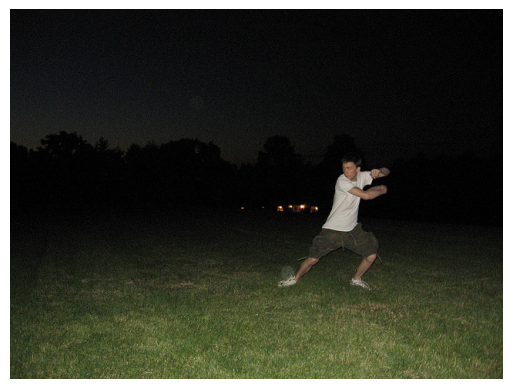

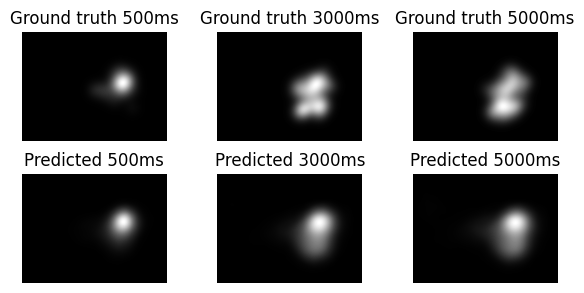

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000000257.jpg


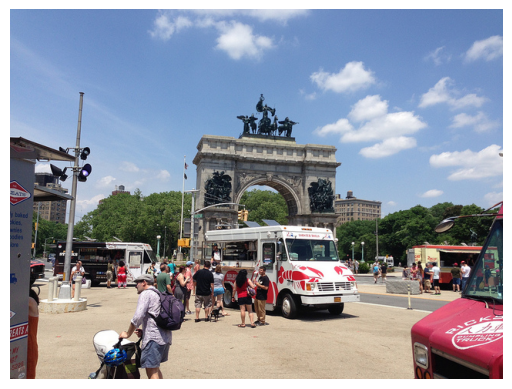

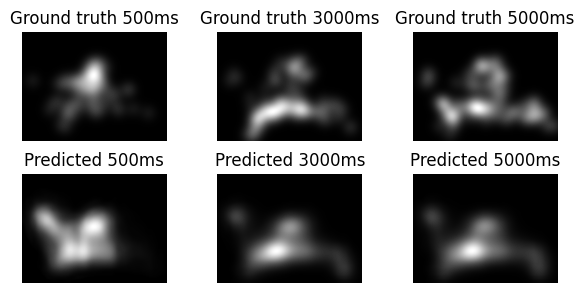

1/1 [==============================] - 2s 2s/step
COCO_val2014_000000000692.jpg


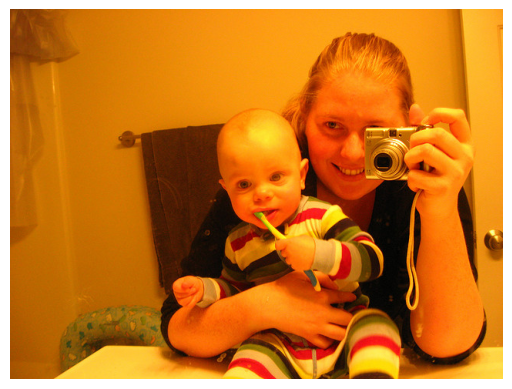

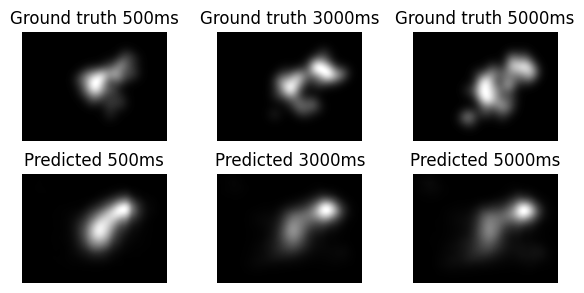

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000000939.jpg


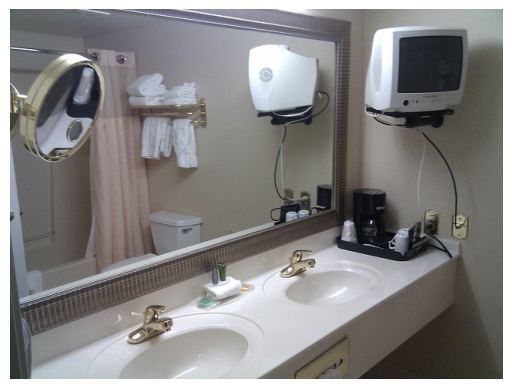

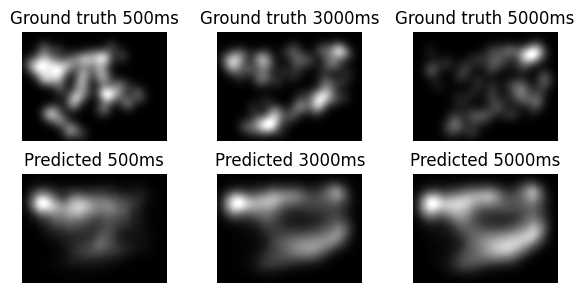

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000001561.jpg


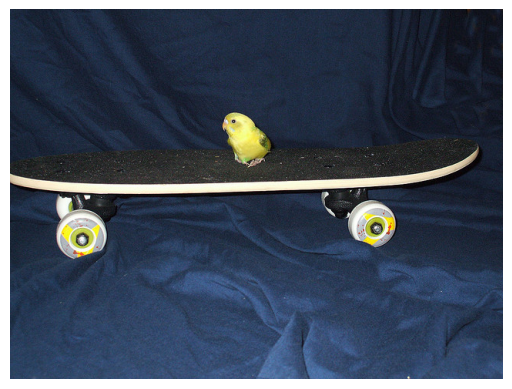

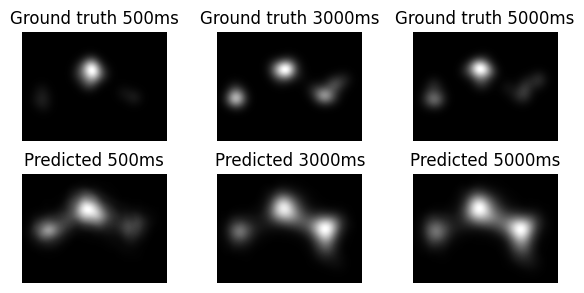

In [12]:
# Set paths
img_path = ''
map_path = ''

# constants
nimages = 5
time_pts = [500, 3000, 5000]

x = os.listdir(img_path)
np.random.shuffle(x)

for i, f in enumerate(x):
  if i == nimages:
    break

  # load ground truth maps
  maps = (
    cv2.imread(f'{map_path}/{f.replace(".jpg", "_0.png")}', cv2.IMREAD_GRAYSCALE), # 0-1s
    cv2.imread(f'{map_path}/{f.replace(".jpg", "_2.png")}', cv2.IMREAD_GRAYSCALE), # 2-3s
    cv2.imread(f'{map_path}/{f.replace(".jpg", "_4.png")}', cv2.IMREAD_GRAYSCALE)  # 4-5s
  )

  image = cv2.imread(f'{img_path}/{f}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  plt.imshow(image)
  plt.axis('off')

  fig, axes = plt.subplots(2,3, figsize=(6,3))

  for ax in axes.flatten():
      ax.axis('off')

  for j, map in enumerate(maps):
    axes[0, j].imshow(map, cmap='gray')
    axes[0, j].set_title(f'Ground truth {time_pts[j]}ms')

  predicted_smaps = model.compute_saliency(image)

  for j, map in enumerate(predicted_smaps):
    axes[1, j].imshow(map, cmap='gray')
    axes[1, j].set_title(f'Predicted {time_pts[j]}ms')

  plt.tight_layout(pad=1)
  print(f)
  plt.show()

## Usage

### Image cropping
For each viewing duration, we use the [yiling-chen/flickr-cropping-dataset](https://github.com/mzhangyb/flickr-cropping-dataset/) \(based on this [paper](https://yiling-chen.github.io/flickr-cropping-dataset/)) to identify a crop that contains 90% of the cumulative saliency.

In [13]:
def saliency_crop(img: np.ndarray, smap: np.ndarray, maxDiff: bool = False) -> Tuple[int, int, int, int]:
  integ_sal_map = cv2.integral(smap)	# integral image for fast block sum computation

  height = img.shape[0]
  width = img.shape[1]

  best_x = -1
  best_y = -1
  best_w = -1
  best_h = -1
  best_score = -1.0

  # uniform scaling
  scales = [0.5, 0.6, 0.7, 0.8, 0.9]
  for scale in scales:
   w = int(width * scale)
   h = int(height * scale)

   # generate the grid vertices of sliding windows
   X = [x for x in range(0, width, int(round((width-w)/5.0))) if x < width - w]
   Y = [y for y in range(0, height, int(round((height-h)/5.0))) if y < height - h]

   for x, y in product(X, Y):
     if maxDiff == True:		# maximum saliency difference betwen the cropped window and the rest region
       avg_sal = (integ_sal_map[y][x] + integ_sal_map[y+h][x+w] - integ_sal_map[y+h][x] - integ_sal_map[y][x+w]) / float(w * h)
       outer_avg_sal = (integ_sal_map[height][width] - integ_sal_map[y][x] - integ_sal_map[y+h][x+w] +
         integ_sal_map[y+h][x] + integ_sal_map[y][x+w]) / float(width * height - w * h)
       score = avg_sal - outer_avg_sal
     else:	# average saliency
       score = (integ_sal_map[y][x] + integ_sal_map[y+h][x+w] - integ_sal_map[y+h][x] - integ_sal_map[y][x+w]) / float(w * h)

     if score > best_score:
       best_x = x
       best_y = y
       best_w = w
       best_h = h
       best_score = score

  return (best_x, best_y, best_w, best_h)

1/1 [==============================] - 2s 2s/step
COCO_val2014_000000000589.jpg


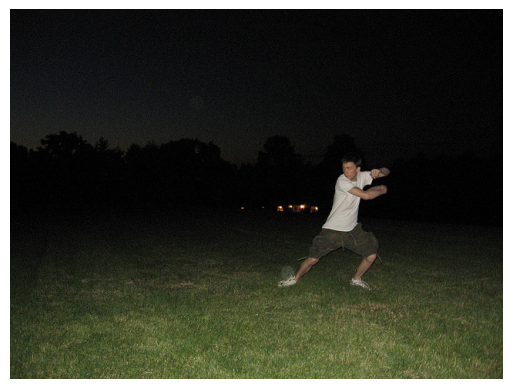

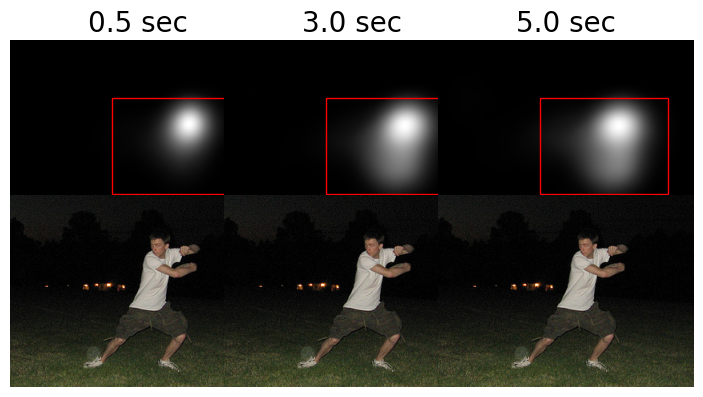

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000000257.jpg


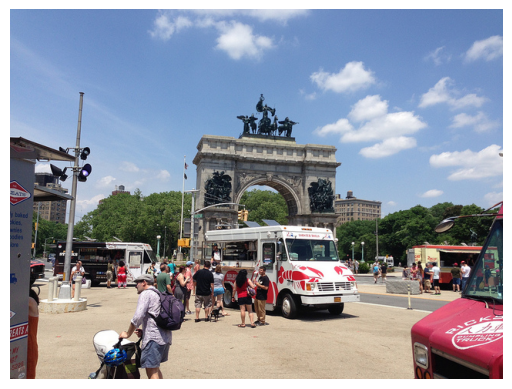

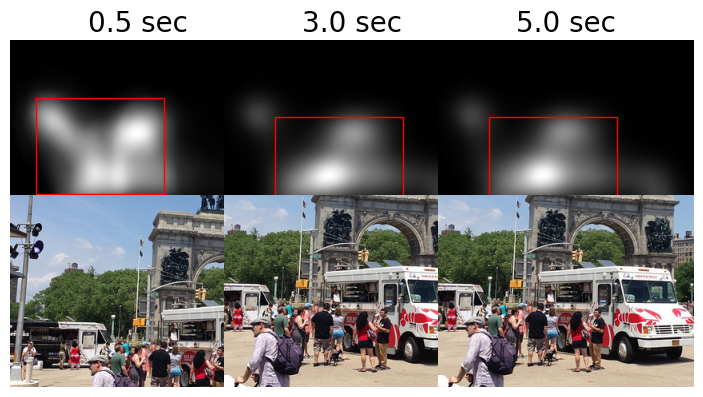

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000000692.jpg


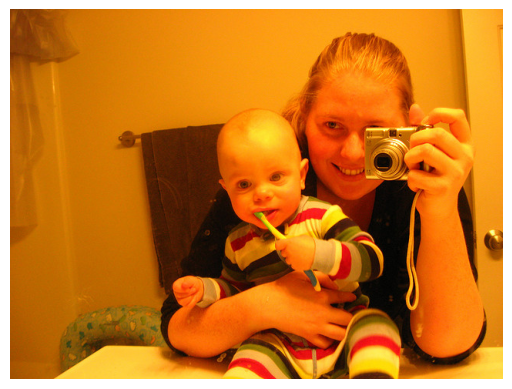

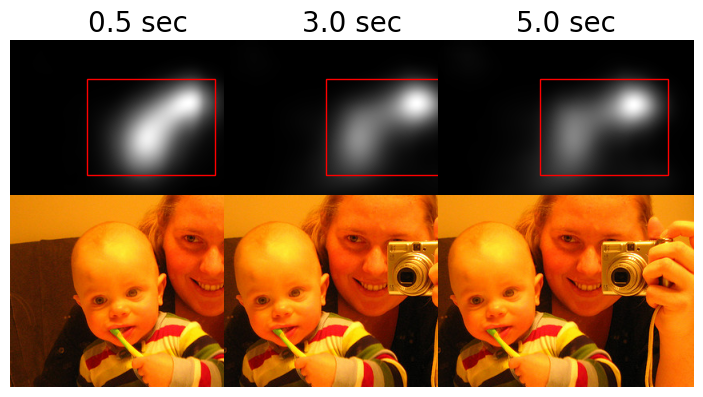

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000000939.jpg


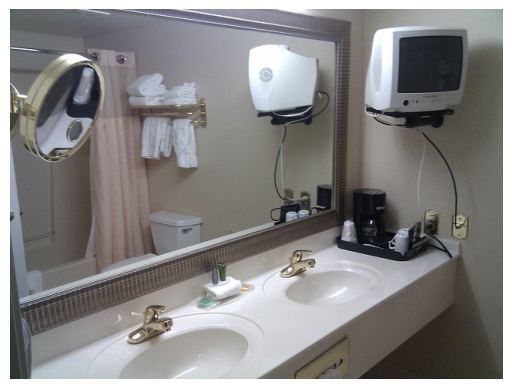

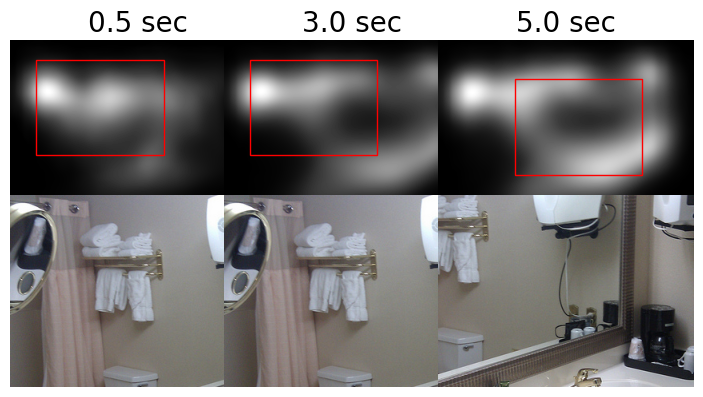

1/1 [==============================] - 1s 1s/step
COCO_val2014_000000001561.jpg


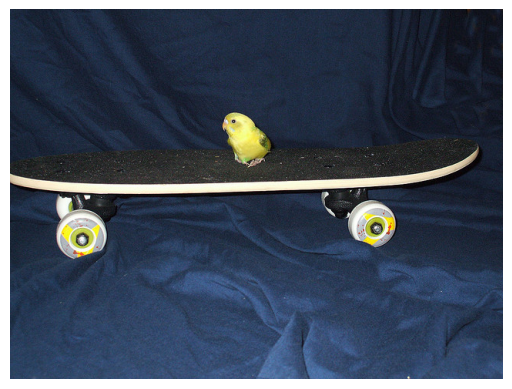

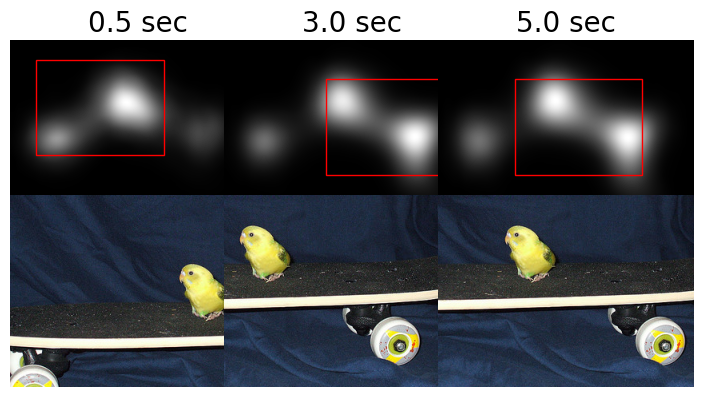

In [14]:
# constants
time_pts = [500, 3000, 5000]

# Set paths
img_path = ''
map_path = ''

nimages = 5

x = os.listdir(img_path)
np.random.shuffle(x)

# display results
for i, f in enumerate(x):
  if i == nimages:
    break

  image = cv2.imread(f'{img_path}/{f}')
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  predicted_smaps = model.compute_saliency(image)

  plt.imshow(image)
  plt.axis('off')

  fig, axes = plt.subplots(2,3, figsize=(6,3))
  axes = axes.flatten()

  for ax in axes:
      ax.axis('off')

  heatmap_list = []

  for i, (time, smap) in enumerate(zip(time_pts, predicted_smaps)):
      current_heatmap = cv2.resize(smap, (640, 480), interpolation=cv2.INTER_LINEAR)
      best_x, best_y, best_w, best_h = saliency_crop(image, current_heatmap, maxDiff=False)
      axes[i].set_title("{} sec".format(time_pts[i]/1000), fontsize=20)
      rect = Rectangle((best_x, best_y),best_w, best_h, color='r', fill=False)
      axes[i].imshow(current_heatmap, cmap='gray')
      axes[i].add_patch(rect)
      axes[i+3].imshow(image[best_y:best_y+best_h,best_x:best_x+best_w,:])
  plt.tight_layout(pad=-3)
  print(f)
  plt.show()